# Data

In [ ]:
from utils_pde.utils_pde_poisson import Poisson1D
import torch
import torch.nn as nn
import math
import numpy as np

# Analytical solution
u_star = lambda x: np.sin(math.pi * x)

# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

# Data noise
data_noise = 0.15

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing da|ta of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(100, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)


# Alpha
alpha=0.05

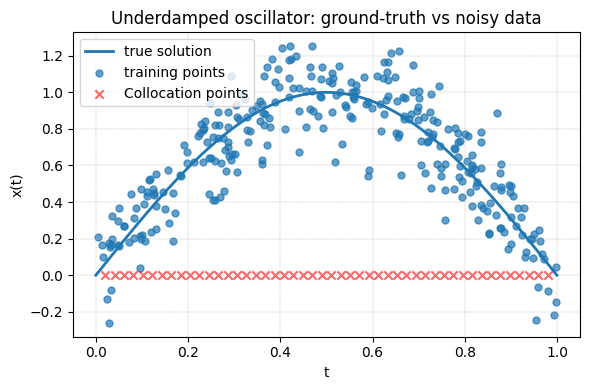

In [27]:
from utils_tools.utils_result_viz import plot_truth_and_samples_1D

plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

# UQ Model with VI

In [17]:
from utils_uqmd.utils_uq_vi import VIBPINN
vibpinn = VIBPINN(
    pde,
    1,[16, 32, 32, 16], 1
)
loss_dict = vibpinn.fit(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=20000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0,)

ep     0 | L=2.36e+03 | elbo=8.42e+01 | pde=2.28e+03  ic=0.00e+00  bc=7.71e-03 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     1 | L=2.36e+03 | elbo=8.04e+01 | pde=2.28e+03  ic=0.00e+00  bc=1.18e-03 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   200 | L=2.38e+02 | elbo=8.98e+01 | pde=1.45e+02  ic=0.00e+00  bc=3.91e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   400 | L=5.77e+01 | elbo=4.02e+01 | pde=1.74e+01  ic=0.00e+00  bc=7.08e-02 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   600 | L=5.80e+01 | elbo=5.14e+01 | pde=6.01e+00  ic=0.00e+00  bc=6.65e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   800 | L=2.66e+01 | elbo=1.94e+01 | pde=7.10e+00  ic=0.00e+00  bc=1.09e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1000 | L=5.78e+01 | elbo=2.87e+01 | pde=2.90e+01  ic=0.00e+00  bc=6.09e-02 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1200 | L=3.47e+01 | elbo=2.96e+01 | pde=5.02e+00  ic=0.00e+00  bc=7.79e-02 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1400 | L=2.1

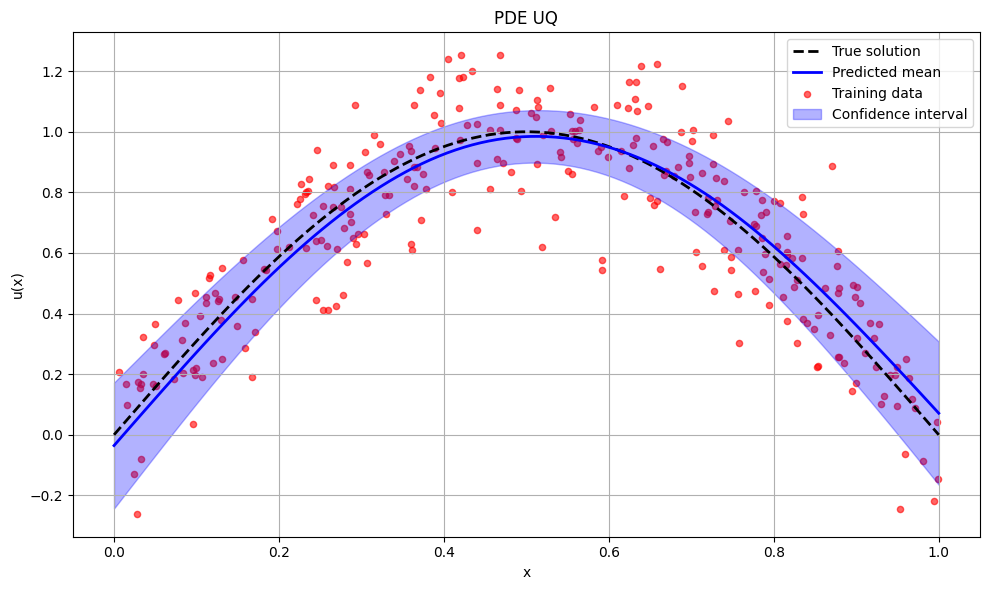

In [28]:
# Prediction
grid_test = torch.linspace(0, 1, 100).view(-1, 1)
uncal_predset = vibpinn.predict(alpha, grid_test)

# Visualization
from utils_tools.utils_result_viz import plot_predictions_1D
plot_predictions_1D(grid_test, uncal_predset, u_star, X=X_train, Y=Y_train)

# CP VI Model

In [29]:
from utils_uqmd.utils_uq_cp import CP
cp_vi = CP(vibpinn)

cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",              
}
cal_predset = cp_vi.predict(alpha, grid_test, **cp_pred_kwargs)

# Plot the CP effect

In [32]:
from matplotlib import pyplot as plt
import os
os.makedirs("CP_demo", exist_ok=True)
# Naive Prediction
n_lower, n_upper = uncal_predset
n_lower = n_lower.flatten()
n_upper = n_upper.flatten()
# Compute prediction mean
n_pred_mean = (n_lower + n_upper) / 2

# Comformal Prediction
cp_lower, cp_upper = cal_predset
cp_lower = cp_lower.flatten()
cp_upper = cp_upper.flatten()
# Compute prediction mean
cp_pred_mean = (cp_lower + cp_upper) / 2

true_solution_np = u_star(grid_test)
# Plot everything
plt.figure(figsize=(8, 5))
plt.plot(grid_test, true_solution_np, 'k--', label='True $x(t)$')  # Ground truth function
plt.plot(grid_test, n_pred_mean, 'b', label='Predicted mean')
plt.fill_between(grid_test.flatten(), cp_lower, cp_upper, color='green', alpha=0.5, label='Comformal Prediction band')
plt.fill_between(grid_test.flatten(), n_lower, n_upper, color='blue', alpha=0.3, label='Naive Prediction band')

plt.scatter(X_train, Y_train, color='red', s=10, label='Training data')  # Noisy train
plt.scatter(X_test, Y_test, color='red', s=10)  # True test points

plt.xlabel('Time $t$')
plt.ylabel('Displacement $x$')
plt.title('0.05-Alpha Level VIBPINN Prediction with Conformal Prediction Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("CP_demo/uncal_vs_cal.pdf", bbox_inches="tight")
plt.close()
